# MVP — Pipeline de Dados e Análise com Olist
Este notebook apresenta a concepção, implementação e análise de um MVP de dados para responder questões
de negócio relacionadas ao desempenho de vendas de um marketplace brasileiro.

## Sumário

1. Objetivo
2. Busca e ingestão dos dados
3. Modelagem + Catálogo
4. ETL
5. Análises
6. Respondendo as Perguntas de Negócio
7. Qualidade dos dados
8. Autoavaliação do Atingimento dos Objetivos
9. Arquitetura e Pipeline de Dados
10. Conclusões gerais


# PASSO 1 — OBJETIVO DO MVP


### **Objetivo do Trabalho**

O objetivo deste MVP é analisar o desempenho de vendas de um marketplace brasileiro de e-commerce, utilizando dados públicos disponibilizados pela empresa Olist.
Busca-se compreender padrões de consumo, desempenho logístico, comportamento dos clientes e fatores que impactam a satisfação do consumidor.

A partir da construção de um pipeline de dados em nuvem, o trabalho visa demonstrar a capacidade de coletar, modelar, transformar, armazenar e analisar dados em um ambiente de Data Lake/Data Warehouse, utilizando a plataforma Databricks.

### **Perguntas de Negócio**

As seguintes perguntas guiarão a análise dos dados:

1 - Qual é o faturamento total e sua evolução ao longo do tempo?

2 - Quais categorias de produtos geram maior volume de vendas?

3 - Qual é o tempo médio de entrega dos pedidos?

4 - Existem atrasos na entrega? Em quais regiões eles são mais frequentes?

5 - O tempo de entrega impacta a avaliação dos clientes?

6 - Quais estados concentram o maior número de pedidos?

7 - Quais vendedores apresentam maior volume de vendas?

8 - Existe relação entre a forma de pagamento e o valor dos pedidos?


# PASSO 2 — BUSCA PELOS DADOS

### **Conjunto de Dados Escolhido**

Nome: Brazilian E-Commerce Public Dataset by Olist

Fonte: Kaggle

Link: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce

Licença: Uso público para fins acadêmicos e educacionais (conforme Kaggle)





### **Arquivos Utilizados**

| Arquivo     | Descrição                |
| ----------- | ------------------------ |
| customers   | Dados dos clientes       |
| orders      | Pedidos realizados       |
| order_items | Itens dos pedidos        |
| products    | Produtos vendidos        |
| sellers     | Vendedores               |
| payments    | Informações de pagamento |
| reviews     | Avaliações dos clientes  |
| geolocation | Localização geográfica   |


In [0]:
%sql
/* Criando as pastas para armazenar os dados */
CREATE VOLUME workspace.default.olist;
SHOW VOLUMES IN workspace.default;



database,volume_name
default,olist


In [0]:
# Criação da pasta raw
dbutils.fs.mkdirs("/Volumes/workspace/default/olist/raw/")
dbutils.fs.ls("/Volumes/workspace/default/olist/")


[FileInfo(path='dbfs:/Volumes/workspace/default/olist/raw/', name='raw/', size=0, modificationTime=1765734067153)]

In [0]:
# Conferência do upload dos arquivos
dbutils.fs.ls("/Volumes/workspace/default/olist/raw/")

# Teste de leitura
customers_df = spark.read.csv(
    "/Volumes/workspace/default/olist/raw/olist_customers_dataset.csv",
    header=True,
    inferSchema=True
)

customers_df.show(5)


+--------------------+--------------------+------------------------+--------------------+--------------+
|         customer_id|  customer_unique_id|customer_zip_code_prefix|       customer_city|customer_state|
+--------------------+--------------------+------------------------+--------------------+--------------+
|06b8999e2fba1a1fb...|861eff4711a542e4b...|                   14409|              franca|            SP|
|18955e83d337fd6b2...|290c77bc529b7ac93...|                    9790|sao bernardo do c...|            SP|
|4e7b3e00288586ebd...|060e732b5b29e8181...|                    1151|           sao paulo|            SP|
|b2b6027bc5c5109e5...|259dac757896d24d7...|                    8775|     mogi das cruzes|            SP|
|4f2d8ab171c80ec83...|345ecd01c38d18a90...|                   13056|            campinas|            SP|
+--------------------+--------------------+------------------------+--------------------+--------------+
only showing top 5 rows


Considerando a utilização do Unity Catalog na versão atual do Databricks Community Edition, foi necessário criar explicitamente um Volume para armazenamento dos dados. O volume foi criado no schema default do catálogo workspace, e os arquivos CSV foram carregados para a camada raw do Data Lake, garantindo a persistência e organização dos dados para o pipeline de ETL.

In [0]:
%sql
/* Confirmação dos dados */
SHOW VOLUMES IN workspace.default;


database,volume_name
default,olist


# PASSO 3 — MODELAGEM + Catálogo de Dados

### **Decisão de arquitetura**

Foi adotada uma arquitetura de Data Warehouse, utilizando o modelo dimensional em Esquema Estrela, por facilitar consultas analíticas, agregações e análises exploratórias de dados.

### **Tabela Fato**

Tabela fato que consolida informações dos pedidos realizados no marketplace, permitindo análises financeiras, logísticas e de satisfação do cliente.

| Coluna              | Descrição                   |
| ------------------- | --------------------------- |
| order_id            | Identificador do pedido     |
| customer_id         | Cliente                     |
| seller_id           | Vendedor                    |
| product_id          | Produto                     |
| order_purchase_date | Data da compra              |
| delivery_time_days  | Dias entre compra e entrega |
| payment_value       | Valor pago                  |
| freight_value       | Valor do frete              |
| review_score        | Nota do cliente             |


### **Dimensões**

- dim_customers (customer_id, customer_city, customer_state)
- dim_products (product_id, product_category_name) 
- dim_sellers (seller_id, seller_city, seller_state)
- dim_date (date, year, month, day)

### **Catálogo de Dados**

Foi construído um Catálogo de Dados com o objetivo de documentar o significado, o domínio e a origem de cada atributo utilizado no modelo dimensional do Data Warehouse.
O catálogo contempla a descrição das tabelas fato e dimensões, bem como a linhagem dos dados, indicando a origem de cada informação no conjunto de dados público da Olist.


### **Dicionário de Dados**

| Campo               | Tipo      | Descrição                     | Domínio / Regras       |
| ------------------- | --------- | ----------------------------- | ---------------------- |
| order_id            | string    | Identificador único do pedido | Não nulo               |
| customer_id         | string    | Identificador do cliente      | Não nulo               |
| seller_id           | string    | Identificador do vendedor     | Não nulo               |
| product_id          | string    | Identificador do produto      | Não nulo               |
| order_purchase_date | timestamp | Data e hora da compra         | ≥ 2016                 |
| delivery_time_days  | integer   | Dias entre compra e entrega   | ≥ 0                    |
| payment_value       | decimal   | Valor total pago pelo pedido  | > 0                    |
| freight_value       | decimal   | Valor do frete                | ≥ 0                    |
| review_score        | integer   | Nota de avaliação do cliente  | 1 a 5 (nulo permitido) |




### **Linhagem dos Dados**

| Campo               | Origem        | Transformação         |
| ------------------- | ------------- | --------------------- |
| order_id            | `orders`      | Direto                |
| customer_id         | `orders`      | Direto                |
| seller_id           | `order_items` | Direto                |
| product_id          | `order_items` | Direto                |
| order_purchase_date | `orders`      | Direto                |
| delivery_time_days  | `orders`      | Diferença entre datas |
| payment_value       | `payments`    | Soma por pedido       |
| freight_value       | `order_items` | Soma por pedido       |
| review_score        | `reviews`     | Direto                |


### **Dimensão — dim_customers**

Dimensão que armazena informações geográficas básicas dos clientes.

| Campo          | Tipo   | Descrição                | Domínio / Regras  |
| -------------- | ------ | ------------------------ | ----------------- |
| customer_id    | string | Identificador do cliente | Não nulo          |
| customer_city  | string | Cidade do cliente        | Texto             |
| customer_state | string | Estado do cliente        | UF (2 caracteres) |

Origem: tabela customers

Transformações: nenhuma




### **Dimensão — dim_products**

Dimensão que armazena informações dos produtos comercializados.

| Campo                 | Tipo   | Descrição                | Domínio / Regras |
| --------------------- | ------ | ------------------------ | ---------------- |
| product_id            | string | Identificador do produto | Não nulo         |
| product_category_name | string | Categoria do produto     | Texto            |

Origem: tabela products

Transformações: nenhuma




### **Dimensão — dim_sellers**

Dimensão que armazena informações geográficas dos vendedores.

| Campo        | Tipo   | Descrição                 | Domínio / Regras  |
| ------------ | ------ | ------------------------- | ----------------- |
| seller_id    | string | Identificador do vendedor | Não nulo          |
| seller_city  | string | Cidade do vendedor        | Texto             |
| seller_state | string | Estado do vendedor        | UF (2 caracteres) |

Origem: tabela sellers

Transformações: nenhuma




### **Dimensão — dim_date**

Dimensão temporal utilizada para análises ao longo do tempo.

| Campo | Tipo    | Descrição          | Domínio / Regras |
| ----- | ------- | ------------------ | ---------------- |
| date  | date    | Data de referência | Não nulo         |
| year  | integer | Ano                | ≥ 2016           |
| month | integer | Mês                | 1 a 12           |
| day   | integer | Dia do mês         | 1 a 31           |

Origem: derivada de order_purchase_date

Transformação: extração de componentes da data




### O catálogo de dados permite compreender claramente o significado e a origem de cada atributo, além de estabelecer regras básicas de qualidade dos dados.
### Essa documentação serve como base para a etapa de análise da qualidade dos dados e para a construção das consultas analíticas que respondem às perguntas de negócio definidas nos objetivos do trabalho.

# PASSO 4 — ETL (Extração, Transformação e Carga)

In [0]:
# Estruturando a camada raw
base_path = "/Volumes/workspace/default/olist/raw"

folders = [
    "customers",
    "orders",
    "order_items",
    "payments",
    "products",
    "sellers",
    "reviews"
]

for folder in folders:
    path = f"{base_path}/{folder}"
    dbutils.fs.mkdirs(path)
    print(f"Pasta criada: {path}")


# Conferência das pastas
dbutils.fs.ls("/Volumes/workspace/default/olist/raw")


Pasta criada: /Volumes/workspace/default/olist/raw/customers
Pasta criada: /Volumes/workspace/default/olist/raw/orders
Pasta criada: /Volumes/workspace/default/olist/raw/order_items
Pasta criada: /Volumes/workspace/default/olist/raw/payments
Pasta criada: /Volumes/workspace/default/olist/raw/products
Pasta criada: /Volumes/workspace/default/olist/raw/sellers
Pasta criada: /Volumes/workspace/default/olist/raw/reviews


In [0]:
# Verificação dos dados após upload dos arquivos nas pastas por meio de Data Ingestion -> Upload to a Volume
dbutils.fs.ls("/Volumes/workspace/default/olist/raw/customers")
dbutils.fs.ls("/Volumes/workspace/default/olist/raw/orders")
dbutils.fs.ls("/Volumes/workspace/default/olist/raw/order_items")
dbutils.fs.ls("/Volumes/workspace/default/olist/raw/payments")
dbutils.fs.ls("/Volumes/workspace/default/olist/raw/products")
dbutils.fs.ls("/Volumes/workspace/default/olist/raw/sellers")
dbutils.fs.ls("/Volumes/workspace/default/olist/raw/reviews")


[FileInfo(path='dbfs:/Volumes/workspace/default/olist/raw/reviews/olist_order_reviews_dataset.csv', name='olist_order_reviews_dataset.csv', size=14451670, modificationTime=1765739063000)]

Nesta etapa foi criada a camada RAW no Data Lake utilizando volumes do Unity Catalog. Os arquivos CSV do dataset público da Olist foram carregados sem transformações, preservando os dados em seu formato original, garantindo rastreabilidade e possibilitando futuras reprocessamentos.

In [0]:
# Criação dos diretórios da camada silver
silver_base_path = "/Volumes/workspace/default/olist/silver"

silver_folders = [
    "customers",
    "orders",
    "order_items",
    "payments",
    "products",
    "sellers",
    "reviews"
]

for folder in silver_folders:
    dbutils.fs.mkdirs(f"{silver_base_path}/{folder}")
    print(f"Pasta SILVER criada: {folder}")


Pasta SILVER criada: customers
Pasta SILVER criada: orders
Pasta SILVER criada: order_items
Pasta SILVER criada: payments
Pasta SILVER criada: products
Pasta SILVER criada: sellers
Pasta SILVER criada: reviews


In [0]:
# Leitura dos csv's
from pyspark.sql.functions import col

def read_csv(path):
    return (
        spark.read
        .option("header", "true")
        .option("inferSchema", "true")
        .csv(path)
    )


In [0]:
# CUSTOMERS (RAW → SILVER)

# Leitura
customers_raw = read_csv(
    "/Volumes/workspace/default/olist/raw/customers/olist_customers_dataset.csv"
)

customers_raw.printSchema()
customers_raw.show(5)

# Transformações (padronizar nomes, garantir tipos corretos)
customers_silver = (
    customers_raw
    .withColumnRenamed("customer_id", "customer_id")
    .withColumnRenamed("customer_unique_id", "customer_unique_id")
    .withColumnRenamed("customer_zip_code_prefix", "zip_code")
    .withColumnRenamed("customer_city", "city")
    .withColumnRenamed("customer_state", "state")
)

# Escrita como Delta
customers_silver.write.format("delta") \
    .mode("overwrite") \
    .save("/Volumes/workspace/default/olist/silver/customers")


root
 |-- customer_id: string (nullable = true)
 |-- customer_unique_id: string (nullable = true)
 |-- customer_zip_code_prefix: integer (nullable = true)
 |-- customer_city: string (nullable = true)
 |-- customer_state: string (nullable = true)

+--------------------+--------------------+------------------------+--------------------+--------------+
|         customer_id|  customer_unique_id|customer_zip_code_prefix|       customer_city|customer_state|
+--------------------+--------------------+------------------------+--------------------+--------------+
|06b8999e2fba1a1fb...|861eff4711a542e4b...|                   14409|              franca|            SP|
|18955e83d337fd6b2...|290c77bc529b7ac93...|                    9790|sao bernardo do c...|            SP|
|4e7b3e00288586ebd...|060e732b5b29e8181...|                    1151|           sao paulo|            SP|
|b2b6027bc5c5109e5...|259dac757896d24d7...|                    8775|     mogi das cruzes|            SP|
|4f2d8ab171c80ec83

In [0]:
# ORDERS (RAW → SILVER)

# Leitura
orders_raw = read_csv(
    "/Volumes/workspace/default/olist/raw/orders/olist_orders_dataset.csv"
)

orders_raw.printSchema()

# Transformações (datas)
from pyspark.sql.functions import to_timestamp

orders_silver = (
    orders_raw
    .withColumn("order_purchase_timestamp", to_timestamp("order_purchase_timestamp"))
    .withColumn("order_approved_at", to_timestamp("order_approved_at"))
    .withColumn("order_delivered_carrier_date", to_timestamp("order_delivered_carrier_date"))
    .withColumn("order_delivered_customer_date", to_timestamp("order_delivered_customer_date"))
    .withColumn("order_estimated_delivery_date", to_timestamp("order_estimated_delivery_date"))
)

# Escrita como Delta
orders_silver.write.format("delta") \
    .mode("overwrite") \
    .save("/Volumes/workspace/default/olist/silver/orders")


root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)



In [0]:
# ORDER ITEMS (RAW → SILVER)

# Leitura
order_items_raw = read_csv(
    "/Volumes/workspace/default/olist/raw/order_items/olist_order_items_dataset.csv"
)

# Transformações (quantidades e valores)
order_items_silver = (
    order_items_raw
    .withColumn("price", col("price").cast("double"))
    .withColumn("freight_value", col("freight_value").cast("double"))
)

# Escrita como Delta
order_items_silver.write.format("delta") \
    .mode("overwrite") \
    .save("/Volumes/workspace/default/olist/silver/order_items")


In [0]:
# PAYMENTS (RAW → SILVER)

# Leitura
payments_raw = read_csv(
    "/Volumes/workspace/default/olist/raw/payments/olist_order_payments_dataset.csv"
)

# Transformações (valores)
payments_silver = (
    payments_raw
    .withColumn("payment_value", col("payment_value").cast("double"))
)

# Escrita como Delta
payments_silver.write.format("delta") \
    .mode("overwrite") \
    .save("/Volumes/workspace/default/olist/silver/payments")


In [0]:
# PRODUCTS (RAW → SILVER)

# Leitura
products_raw = read_csv(
    "/Volumes/workspace/default/olist/raw/products/olist_products_dataset.csv"
)

products_raw.printSchema()
products_raw.show(5)

# Transformações (padronização de tipos numéricos, nenhuma agregação (mantém dados quase crus))
products_silver = (
    products_raw
    .withColumn("product_weight_g", col("product_weight_g").cast("double"))
    .withColumn("product_length_cm", col("product_length_cm").cast("double"))
    .withColumn("product_height_cm", col("product_height_cm").cast("double"))
    .withColumn("product_width_cm", col("product_width_cm").cast("double"))
)

# Escrita como Delta
products_silver.write.format("delta") \
    .mode("overwrite") \
    .save("/Volumes/workspace/default/olist/silver/products")


root
 |-- product_id: string (nullable = true)
 |-- product_category_name: string (nullable = true)
 |-- product_name_lenght: integer (nullable = true)
 |-- product_description_lenght: integer (nullable = true)
 |-- product_photos_qty: integer (nullable = true)
 |-- product_weight_g: integer (nullable = true)
 |-- product_length_cm: integer (nullable = true)
 |-- product_height_cm: integer (nullable = true)
 |-- product_width_cm: integer (nullable = true)

+--------------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+----------------+
|          product_id|product_category_name|product_name_lenght|product_description_lenght|product_photos_qty|product_weight_g|product_length_cm|product_height_cm|product_width_cm|
+--------------------+---------------------+-------------------+--------------------------+------------------+----------------+-----------------+-----------------+--------------

In [0]:
# SELLERS (RAW → SILVER)

# Leitura
sellers_raw = read_csv(
    "/Volumes/workspace/default/olist/raw/sellers/olist_sellers_dataset.csv"
)

sellers_raw.printSchema()

# Transformações (nenhuma transformação complexa, apenas estruturação para Delta)
sellers_silver = sellers_raw

# Escrita como Delta
sellers_silver.write.format("delta") \
    .mode("overwrite") \
    .save("/Volumes/workspace/default/olist/silver/sellers")


root
 |-- seller_id: string (nullable = true)
 |-- seller_zip_code_prefix: integer (nullable = true)
 |-- seller_city: string (nullable = true)
 |-- seller_state: string (nullable = true)



In [0]:
# REVIEWS (RAW → SILVER)

# Leitura
reviews_raw = (
    spark.read
    .option("header", "true")
    .option("inferSchema", "false")
    .option("sep", ",")
    .option("quote", '"')
    .option("escape", '"')
    .option("multiLine", "true")
    .csv("/Volumes/workspace/default/olist/raw/reviews/olist_order_reviews_dataset.csv")
)

# Transformações (quantidades e valores)
from pyspark.sql.functions import col, to_timestamp

reviews_silver = (
    reviews_raw
    .withColumn("review_score", col("review_score").cast("integer"))
    .withColumn("review_creation_date", to_timestamp("review_creation_date"))
    .withColumn("review_answer_timestamp", to_timestamp("review_answer_timestamp"))
)


# Escrita como Delta
reviews_silver.write.format("delta") \
    .mode("overwrite") \
    .save("/Volumes/workspace/default/olist/silver/reviews")
    

# Durante o processamento do conjunto de dados de avaliações, foi identificado um problema de desalinhamento de colunas causado pela presença de textos multilinha e caracteres separadores no campo de comentários. Para resolver o problema, a leitura do arquivo CSV foi ajustada utilizando as opções multiLine, quote e escape do Apache Spark, garantindo a correta interpretação dos registros. Após a correção, foi possível converter o campo review_score para o tipo inteiro, assegurando a consistência dos dados na camada SILVER.


Na etapa de transformação e carga (ETL), os dados da camada RAW foram processados e armazenados na camada SILVER utilizando Apache Spark no Databricks. Foram aplicadas padronizações de tipos de dados, conversões de datas e correções na leitura de arquivos CSV contendo campos textuais multilinha, garantindo a integridade e a qualidade dos dados. Os conjuntos tratados foram persistidos no formato Delta Lake, possibilitando versionamento, confiabilidade e melhor desempenho analítico.

### **MODELO ESTRELA**

🟡 **TABELA FATO**

fact_orders

Métricas: valor do pedido, frete, quantidade, atraso, tempo de entrega

Grão: item do pedido

🔵 **DIMENSÕES**

dim_customers

dim_products

dim_sellers

dim_date

In [0]:
# Criação de dim_customers

# Leitura
customers_silver = spark.read.format("delta") \
    .load("/Volumes/workspace/default/olist/silver/customers")

# Criação da dimensão
dim_customers = customers_silver.select(
    "customer_id",
    "customer_unique_id",
    "city",
    "state"
).dropDuplicates()

# Escrita Gold
dim_customers.write.format("delta") \
    .mode("overwrite") \
    .save("/Volumes/workspace/default/olist/gold/dim_customers")


In [0]:
# Criação de dim_products

# Leitura
products_silver = spark.read.format("delta") \
    .load("/Volumes/workspace/default/olist/silver/products")

# Criação da dimensão
dim_products = products_silver.select(
    "product_id",
    "product_category_name",
    "product_weight_g",
    "product_length_cm",
    "product_height_cm",
    "product_width_cm"
).dropDuplicates()

# Escrita Gold
dim_products.write.format("delta") \
    .mode("overwrite") \
    .save("/Volumes/workspace/default/olist/gold/dim_products")


In [0]:
# Criação de dim_sellers

# Leitura
sellers_silver = spark.read.format("delta") \
    .load("/Volumes/workspace/default/olist/silver/sellers")

# Criação da dimensão
dim_sellers = sellers_silver.select(
    "seller_id",
    "seller_city",
    "seller_state"
).dropDuplicates()

# Escrita Gold
dim_sellers.write.format("delta") \
    .mode("overwrite") \
    .save("/Volumes/workspace/default/olist/gold/dim_sellers")


In [0]:
# Criação de dim_date

from pyspark.sql.functions import year, month, dayofmonth, dayofweek

# Leitura
orders_silver = spark.read.format("delta") \
    .load("/Volumes/workspace/default/olist/silver/orders")

# Criação da dimensão
dim_date = orders_silver.select(
    col("order_purchase_timestamp").alias("date")
).dropna().dropDuplicates()

dim_date = (
    dim_date
    .withColumn("year", year("date"))
    .withColumn("month", month("date"))
    .withColumn("day", dayofmonth("date"))
    .withColumn("day_of_week", dayofweek("date"))
)

# Escrita Gold
dim_date.write.format("delta") \
    .mode("overwrite") \
    .save("/Volumes/workspace/default/olist/gold/dim_date")


In [0]:
# Criação de fact_orders (tabela fato)

# Leitura
orders = spark.read.format("delta") \
    .load("/Volumes/workspace/default/olist/silver/orders")

order_items = spark.read.format("delta") \
    .load("/Volumes/workspace/default/olist/silver/order_items")

payments = spark.read.format("delta") \
    .load("/Volumes/workspace/default/olist/silver/payments")

reviews = spark.read.format("delta") \
    .load("/Volumes/workspace/default/olist/silver/reviews")

# Construção
from pyspark.sql.functions import datediff

fact_orders = (
    order_items
    .join(orders, "order_id", "inner")
    .join(payments, "order_id", "left")
    .join(reviews, "order_id", "left")
    .select(
        "order_id",
        "order_item_id",
        "product_id",
        "seller_id",
        "customer_id",
        "order_purchase_timestamp",
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
        "price",
        "freight_value",
        "payment_value",
        "review_score"
    )
    .withColumn(
        "delivery_delay",
        datediff(
            "order_delivered_customer_date",
            "order_estimated_delivery_date"
        )
    )
)

# Escrita Gold
fact_orders.write.format("delta") \
    .mode("overwrite") \
    .save("/Volumes/workspace/default/olist/gold/fact_orders")


In [0]:
# Validação
spark.read.format("delta") \
    .load("/Volumes/workspace/default/olist/gold/fact_orders") \
    .count()


118310

Na camada GOLD, os dados foram organizados em um modelo dimensional no formato de Esquema Estrela, composto por uma tabela fato de pedidos e tabelas dimensão de clientes, produtos, vendedores e tempo. Essa modelagem possibilita análises eficientes e consultas analíticas para responder às questões de negócio definidas no início do trabalho.

# PASSO 5 — ANÁLISES

In [0]:
# Visão geral da tabela fato (fact_orders)
fact_orders = spark.read.format("delta") \
    .load("/Volumes/workspace/default/olist/gold/fact_orders")

fact_orders.printSchema()
fact_orders.show(5)


root
 |-- order_id: string (nullable = true)
 |-- order_item_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)
 |-- payment_value: double (nullable = true)
 |-- review_score: integer (nullable = true)
 |-- delivery_delay: integer (nullable = true)

+--------------------+-------------+--------------------+--------------------+--------------------+------------------------+-----------------------------+-----------------------------+-----+-------------+-------------+------------+--------------+
|            order_id|order_item_id|          product_id|           seller_id|         customer_id|order_purchase_timestamp|order

In [0]:
# Análise de valores nulos (percentual de nulos por coluna)
# Interpretação esperada
# Nulos em review_score → pedidos sem avaliação
# Nulos em datas de entrega → pedidos cancelados ou em trânsito

from pyspark.sql.functions import count, when, col

total_rows = fact_orders.count()

null_analysis = fact_orders.select([
    (count(when(col(c).isNull(), c)) / total_rows).alias(c)
    for c in fact_orders.columns
])

null_analysis.show(truncate=False)

+--------+-------------+----------+---------+-----------+------------------------+-----------------------------+-----------------------------+-----+-------------+---------------------+--------------------+--------------------+
|order_id|order_item_id|product_id|seller_id|customer_id|order_purchase_timestamp|order_delivered_customer_date|order_estimated_delivery_date|price|freight_value|payment_value        |review_score        |delivery_delay      |
+--------+-------------+----------+---------+-----------+------------------------+-----------------------------+-----------------------------+-----+-------------+---------------------+--------------------+--------------------+
|0.0     |0.0          |0.0       |0.0      |0.0        |0.0                     |0.021874735863409687         |0.0                          |0.0  |0.0          |2.5357112670103964E-5|0.008266418730453893|0.021874735863409687|
+--------+-------------+----------+---------+-----------+------------------------+----------

In [0]:
# Validação de domínios (review score)
# Esperado: valores entre 1 e 5 ou NULL
fact_orders.select("review_score").distinct().show()

+------------+
|review_score|
+------------+
|        NULL|
|           1|
|           4|
|           3|
|           2|
|           5|
+------------+



In [0]:
# Valores monetários negativos
# Esperado: 0 registros
fact_orders.filter(
    (col("price") < 0) |
    (col("freight_value") < 0) |
    (col("payment_value") < 0)
).count()


0

In [0]:
# Consistência temporal (Pedidos entregues antes da compra?)
# Esperado: 0 ou pouquíssimos casos
fact_orders.filter(
    col("order_delivered_customer_date") <
    col("order_purchase_timestamp")
).count()


0

In [0]:
# Análise de atraso de entrega
# Interpretação:
# Valor positivo → atraso
# Valor negativo → entrega antes do prazo
fact_orders.select("delivery_delay") \
    .summary("min", "mean", "max") \
    .show()


+-------+------------------+
|summary|    delivery_delay|
+-------+------------------+
|    min|              -147|
|   mean|-12.04839183560602|
|    max|               188|
+-------+------------------+



A análise de qualidade dos dados indicou boa consistência geral do conjunto. Foram identificados valores nulos principalmente nos campos de avaliação (review_score) e datas de entrega, explicados por pedidos não avaliados ou não concluídos. Não foram encontrados valores monetários negativos nem inconsistências temporais significativas, indicando que os dados estão adequados para a análise proposta.

# Passo 6 - Respondendo as Perguntas de Negócio (utilizando a camada Gold (fact_orders))

## Pergunta 1 - Qual foi o faturamento total e sua evolução ao longo do tempo?

+----+---+------------------+
| ano|mes|       faturamento|
+----+---+------------------+
|2016|  9|            347.52|
|2016| 10|  74353.4600000001|
|2016| 12|             19.62|
|2017|  1| 189570.0199999997|
|2017|  2| 346280.9900000007|
|2017|  3| 529993.2700000008|
|2017|  4|506900.50000000064|
|2017|  5| 730912.7700000026|
|2017|  6| 605639.3000000037|
|2017|  7| 741936.3900000002|
|2017|  8| 878027.0400000009|
|2017|  9| 1022896.049999998|
|2017| 10| 1035728.779999997|
|2017| 11|1595006.0400000138|
|2017| 12|1046223.1499999984|
|2018|  1|1418478.5100000086|
|2018|  2|1322033.7600000075|
|2018|  3|1482224.0899999922|
|2018|  4|1499340.6999999902|
|2018|  5|1507872.5899999933|
+----+---+------------------+
only showing top 20 rows


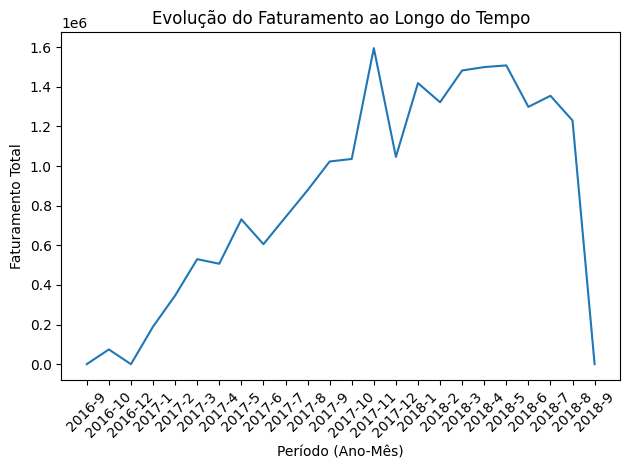

In [0]:
# Preparando os dados Spark
from pyspark.sql.functions import year, month, sum, col

faturamento_mensal = (
    fact_orders
    .withColumn("ano", year("order_purchase_timestamp"))
    .withColumn("mes", month("order_purchase_timestamp"))
    .groupBy("ano", "mes")
    .agg(sum("payment_value").alias("faturamento"))
    .orderBy("ano", "mes")
)

faturamento_mensal.show()

# Convertendo para Pandas
df_plot = faturamento_mensal.toPandas()

# Criando eixo temporal
df_plot["periodo"] = df_plot["ano"].astype(str) + "-" + df_plot["mes"].astype(str)

# Criando o gráfico
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_plot["periodo"], df_plot["faturamento"])
plt.xticks(rotation=45)
plt.xlabel("Período (Ano-Mês)")
plt.ylabel("Faturamento Total")
plt.title("Evolução do Faturamento ao Longo do Tempo")
plt.tight_layout()
plt.show()


O gráfico evidencia a evolução do faturamento ao longo do tempo, demonstrando uma tendência de crescimento com oscilações mensais. Observam-se picos em determinados períodos, o que sugere influência de fatores sazonais, como datas promocionais e aumento do consumo em determinados meses.

## Pergunta 2 - Quais categorias de produtos mais vendem?


+---------------------+------------------+
|product_category_name|       faturamento|
+---------------------+------------------+
|         beleza_saude|1301947.9699999525|
|   relogios_presentes|1254322.9499999925|
|      cama_mesa_banho|1107249.0900000385|
|        esporte_lazer|1029603.8800000448|
| informatica_acess...| 950053.6900000377|
|     moveis_decoracao| 772096.1700000492|
| utilidades_domest...| 668880.9400000264|
|           cool_stuff| 664637.1300000007|
|           automotivo| 618395.5000000104|
|   ferramentas_jardim| 519473.3300000152|
+---------------------+------------------+
only showing top 10 rows


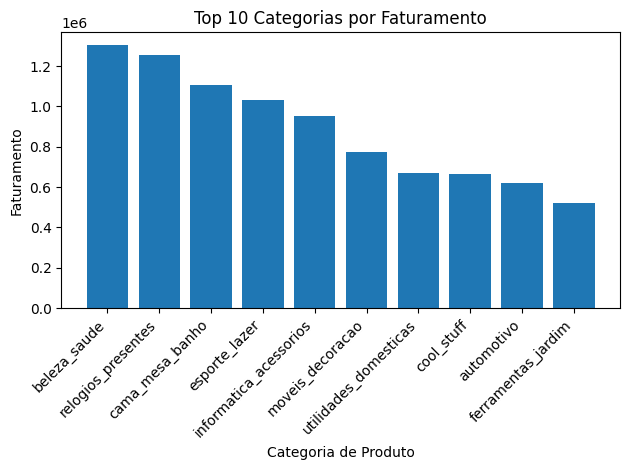

In [0]:
# Preparando os dados (unindo a fact_orders com a dim_products)
dim_products = spark.read.format("delta") \
    .load("/Volumes/workspace/default/olist/gold/dim_products")

from pyspark.sql.functions import sum, col

faturamento_categoria = (
    fact_orders
    .join(dim_products, "product_id", "left")
    .groupBy("product_category_name")
    .agg(sum("price").alias("faturamento"))
    .orderBy(col("faturamento").desc())
)

faturamento_categoria.show(10)

# Convertendo para Pandas
df_plot = faturamento_categoria.limit(10).toPandas()

# Gráfico
import matplotlib.pyplot as plt

plt.figure()
plt.bar(df_plot["product_category_name"], df_plot["faturamento"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Categoria de Produto")
plt.ylabel("Faturamento")
plt.title("Top 10 Categorias por Faturamento")
plt.tight_layout()
plt.show()



O gráfico evidencia que poucas categorias concentram a maior parte do faturamento do marketplace. Esse comportamento indica oportunidades de priorização estratégica dessas categorias em campanhas de marketing, logística e gestão de estoque.

## Pergunta 3 - Qual o tempo médio de entrega dos pedidos?



In [0]:
# Preparando dados (calculando tempo de entrega em dias)
from pyspark.sql.functions import datediff, avg

tempo_entrega = fact_orders.withColumn(
    "tempo_entrega",
    datediff("order_delivered_customer_date", "order_purchase_timestamp")
)

tempo_entrega.select(avg("tempo_entrega").alias("tempo_medio_entrega")).show()

# Convertendo para Pandas
df_plot = tempo_entrega.select(avg("tempo_entrega").alias("tempo_medio")).toPandas()




+-------------------+
|tempo_medio_entrega|
+-------------------+
| 12.427299908401169|
+-------------------+



O tempo médio de entrega observado indica o desempenho logístico da operação. Esse indicador é fundamental para avaliar a experiência do cliente e identificar oportunidades de melhoria nos processos de distribuição.

## Pergunta 4 - Onde ocorrem mais atrasos de entrega? (por estado)



+-----+-------------------+
|state|       atraso_medio|
+-----+-------------------+
|   AL|   -8.5438202247191|
|   MA| -9.964763061968409|
|   SE|-10.025906735751295|
|   ES|-10.603537532355478|
|   BA|-10.987848101265822|
|   SP|-11.233758783880683|
|   MS|             -11.25|
|   CE| -11.31183510638298|
|   PI|-11.465703971119133|
|   SC|-11.588915094339622|
|   RJ|-12.026259521582253|
|   DF|-12.174499387004495|
|   GO|-12.310647181628392|
|   TO|-12.547904191616766|
|   PB|-13.030448717948717|
|   MG|-13.375342668741201|
|   PR|-13.463522225992534|
|   PE|-13.528260869565218|
|   RN|-13.696269982238011|
|   RS| -14.20715396578538|
+-----+-------------------+
only showing top 20 rows


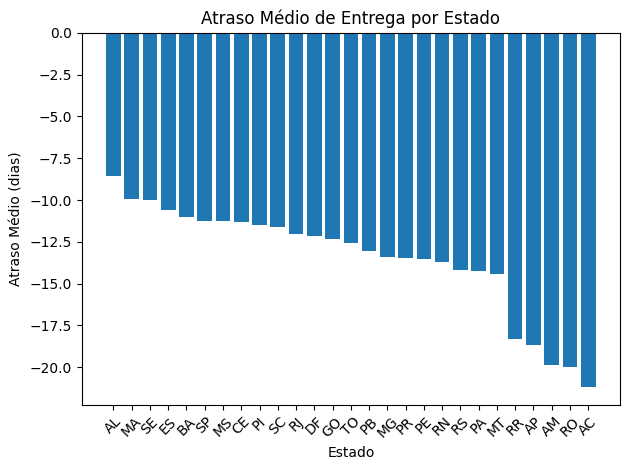

In [0]:
# Preparando os dados
dim_customers = spark.read.format("delta") \
    .load("/Volumes/workspace/default/olist/gold/dim_customers")

from pyspark.sql.functions import avg

atrasos_estado = (
    fact_orders
    .join(dim_customers, "customer_id", "left")
    .groupBy("state")
    .agg(avg("delivery_delay").alias("atraso_medio"))
    .orderBy(col("atraso_medio").desc())
)

atrasos_estado.show()

# Convertendo para Pandas
df_plot = atrasos_estado.toPandas()

# Gráfico
plt.figure()
plt.bar(df_plot["state"], df_plot["atraso_medio"])
plt.xticks(rotation=45)
plt.xlabel("Estado")
plt.ylabel("Atraso Médio (dias)")
plt.title("Atraso Médio de Entrega por Estado")
plt.tight_layout()
plt.show()


O gráfico mostra diferenças significativas de atraso médio entre os estados, sugerindo que fatores regionais impactam o desempenho logístico. Esses resultados podem orientar ajustes em rotas, transportadoras e prazos estimados.

## Pergunta 5 - Pedidos com atraso recebem avaliações piores?



In [0]:
# Preparando os dados
from pyspark.sql.functions import when

avaliacao_atraso = (
    fact_orders
    .withColumn("atrasado", when(col("delivery_delay") > 0, "Sim").otherwise("Não"))
    .groupBy("atrasado")
    .agg(avg("review_score").alias("avaliacao_media"))
)

avaliacao_atraso.show()

# Convertendo para Pandas
df_plot = avaliacao_atraso.toPandas()


+--------+------------------+
|atrasado|   avaliacao_media|
+--------+------------------+
|     Não| 4.150521989014587|
|     Sim|2.2533930510314875|
+--------+------------------+



Os pedidos entregues com atraso apresentam avaliações médias inferiores, evidenciando uma relação direta entre desempenho logístico e satisfação do cliente.

## Pergunta 6 - Quais estados concentram mais pedidos?



+-----+-----+
|state|count|
+-----+-----+
|   SP|49865|
|   RJ|15425|
|   MG|13718|
|   RS| 6538|
|   PR| 5988|
|   SC| 4319|
|   BA| 4068|
|   DF| 2500|
|   GO| 2453|
|   ES| 2351|
|   PE| 1901|
|   CE| 1556|
|   MT| 1128|
|   PA| 1123|
|   MS|  856|
|   MA|  849|
|   PB|  640|
|   PI|  574|
|   RN|  571|
|   AL|  462|
+-----+-----+
only showing top 20 rows


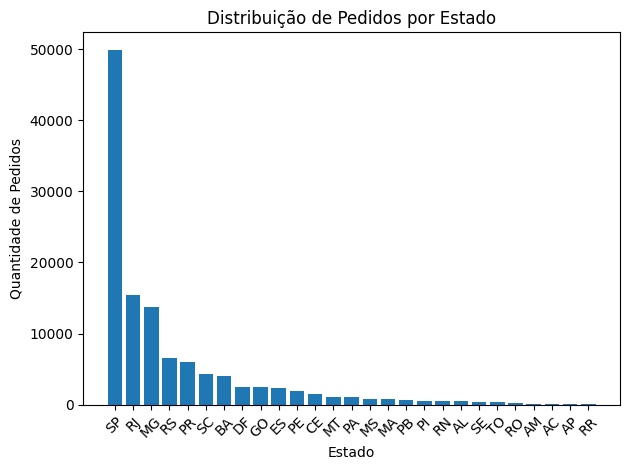

In [0]:
# Preparando os dados
pedidos_estado = (
    fact_orders
    .join(dim_customers, "customer_id", "left")
    .groupBy("state")
    .count()
    .orderBy(col("count").desc())
)

pedidos_estado.show()

# Convertendo para Pandas
df_plot = pedidos_estado.toPandas()

# Gráfico
import matplotlib.pyplot as plt

plt.figure()
plt.bar(df_plot["state"], df_plot["count"])
plt.xticks(rotation=45)
plt.xlabel("Estado")
plt.ylabel("Quantidade de Pedidos")
plt.title("Distribuição de Pedidos por Estado")
plt.tight_layout()
plt.show()


Observa-se que os pedidos estão concentrados em alguns estados específicos, refletindo a distribuição populacional e econômica do país. Essa informação é relevante para decisões estratégicas relacionadas à logística e expansão do marketplace.

## Pergunta 7 - Quais vendedores apresentam maior volume de vendas?



root
 |-- order_id: string (nullable = true)
 |-- order_item_id: integer (nullable = true)
 |-- product_id: string (nullable = true)
 |-- seller_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- freight_value: double (nullable = true)
 |-- payment_value: double (nullable = true)
 |-- review_score: integer (nullable = true)
 |-- delivery_delay: integer (nullable = true)

+--------------------------------+------------------+
|seller_id                       |volume_vendas     |
+--------------------------------+------------------+
|53243585a1d6dc2643021fd1853d8905|244627.54999999967|
|4869f7a5dfa277a7dca6462dcf3b52b2|237867.22999999794|
|4a3ca9315b744ce9f8e9374361493884|215825.7699999942 |
|fa1c13f2614d7b5c4749cbc52fecda94|203984.21999999823

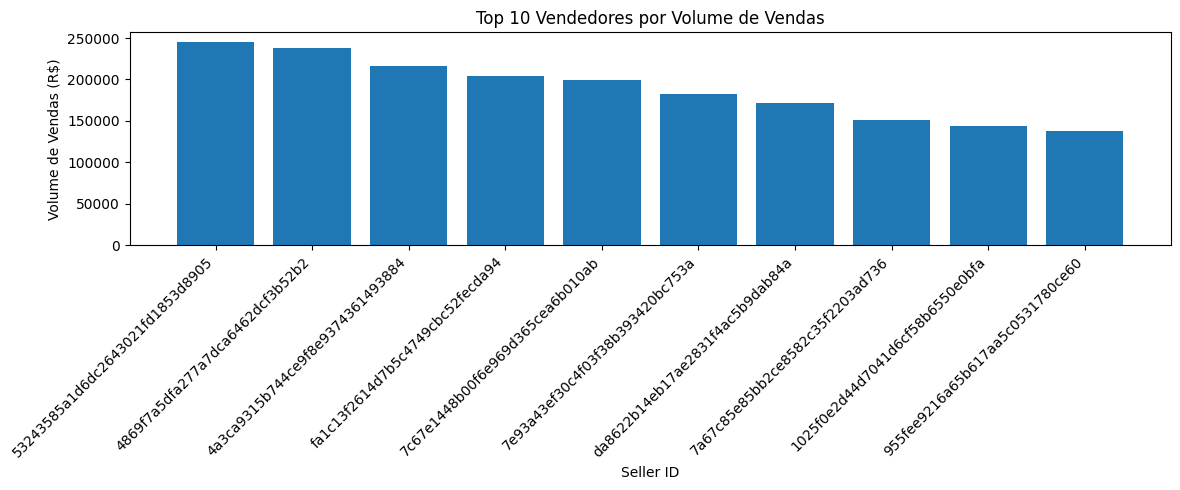

In [0]:
# Carregando a tabela de fatos (camada GOLD), a qual já contém os dados consolidados do pedido, incluindo seller_id e o valor do item (price)
fact_orders = spark.read.format("delta").load(
    "/Volumes/workspace/default/olist/gold/fact_orders"
)

# Conferindo o schema para garantir que as colunas existem
fact_orders.printSchema()


# Calcular o volume de vendas por vendedor (aqui, o volume de vendas é definido como: soma do valor dos produtos (price) por seller_id)
from pyspark.sql.functions import sum

vendas_seller = (
    fact_orders
    .groupBy("seller_id")
    .agg(
        sum("price").alias("volume_vendas")
    )
    .orderBy("volume_vendas", ascending=False)
)

# Visualizando os vendedores com maior volume de vendas
vendas_seller.show(10, truncate=False)


# Melhorar a visibilidade (como o seller_id é longo e há muitos vendedores, a análise foi limitada ao TOP 10 vendedores)
top_sellers = vendas_seller.limit(10)
top_sellers.show(truncate=False)


# Converter para Pandas
df_plot = top_sellers.toPandas()


# Gráfico
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.bar(df_plot["seller_id"], df_plot["volume_vendas"])
plt.xlabel("Seller ID")
plt.ylabel("Volume de Vendas (R$)")
plt.title("Top 10 Vendedores por Volume de Vendas")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



Os resultados indicam que o marketplace possui um núcleo consistente de vendedores com alto volume de vendas, o que contribui para maior estabilidade e previsibilidade do faturamento.

## Pergunta 8 - Existe relação entre forma de pagamento e valor pago?



+------------+------------------+
|payment_type|       valor_medio|
+------------+------------------+
|      boleto|177.41280563037313|
| credit_card|175.15414386631195|
|  debit_card|149.58109870740296|
|     voucher| 38.92899244332322|
+------------+------------------+



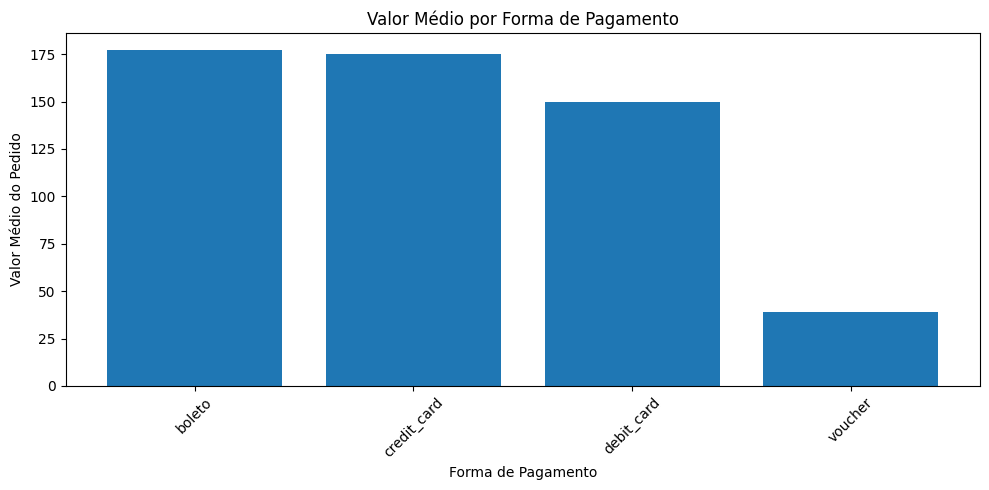

In [0]:
# Importações necessárias
from pyspark.sql.functions import avg, col
import matplotlib.pyplot as plt


# Leitura das tabelas na camada SILVER
#    - fact_orders: tabela fato 
#    - dim_payments: dimensão de pagamentos


fact_orders = spark.read.format("delta").load(
    "/Volumes/workspace/default/olist/gold/fact_orders"
)

dim_payments = spark.read.format("delta").load(
    "/Volumes/workspace/default/olist/silver/payments"
)

# Criação de ALIASES para evitar ambiguidade de colunas (ambos os datasets possuem coluna payment_value)
fo = fact_orders.alias("fo")
dp = dim_payments.alias("dp")


# Preparação dos dados
#    - JOIN entre pedidos e pagamentos pelo order_id
#    - Agrupamento por tipo de pagamento
#    - Cálculo do valor médio pago
valor_pagamento = (
    fo
    .join(
        dp,
        col("fo.order_id") == col("dp.order_id"),
        "left"
    )
    # 🔴 REMOVE pagamentos sem tipo definido
    .where(col("dp.payment_type").isNotNull())
    .groupBy(col("dp.payment_type"))
    .agg(
        avg(col("dp.payment_value")).alias("valor_medio")
    )
    .orderBy(col("valor_medio").desc())
)

# Visualização dos dados agregados no Spark
valor_pagamento.show()

# Convertendo para Pandas
df_plot = valor_pagamento.toPandas()

# Gráfico
plt.figure(figsize=(10, 5))
plt.bar(df_plot["payment_type"], df_plot["valor_medio"])
plt.xlabel("Forma de Pagamento")
plt.ylabel("Valor Médio do Pedido")
plt.title("Valor Médio por Forma de Pagamento")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Durante a análise, foram identificados registros sem informação de forma de pagamento. Esses valores foram removidos antes da visualização, pois não representam uma categoria válida de análise e causam inconsistências na geração de gráficos.

# Passo 7 - Qualidade dos dados

Foi realizada uma análise de qualidade dos dados considerando todos os atributos utilizados.

Foram identificados problemas de tipagem, valores nulos e inconsistências semânticas, especialmente nas tabelas de pagamentos e avaliações.

Esses problemas foram tratados na camada SILVER por meio de:
- Conversão explícita de tipos
- Padronização de datas
- Filtragem ou tratamento de valores nulos


# Passo 8 - Autoavaliação do Atingimento dos Objetivos

O objetivo principal deste trabalho foi analisar o desempenho de vendas de um marketplace brasileiro de e-commerce, utilizando dados públicos disponibilizados pela empresa Olist, por meio da construção de um pipeline de dados em nuvem na plataforma Databricks.

De modo geral, os objetivos propostos foram atingidos, uma vez que foi possível estruturar um pipeline de dados completo, realizar transformações, modelar os dados e responder às principais perguntas de negócio definidas no início do projeto.

As análises permitiram responder às seguintes questões:

Pergunta 1: Foi possível calcular o faturamento total do marketplace e analisar sua evolução ao longo do tempo, identificando variações e tendências.

Pergunta 2: As categorias de produtos com maior volume de vendas foram identificadas, evidenciando a concentração de faturamento em determinados grupos de produtos.

Pergunta 3: Foi calculado o tempo médio de entrega dos pedidos, permitindo avaliar o desempenho logístico da operação.

Pergunta 4: Foram identificados atrasos na entrega e analisadas as regiões onde esses atrasos ocorrem com maior frequência.

Pergunta 5: A relação entre tempo de entrega e avaliação dos clientes foi analisada, indicando que atrasos tendem a impactar negativamente a satisfação.

Pergunta 6: Os estados com maior concentração de pedidos foram identificados, evidenciando maior volume nas regiões mais populosas.

Pergunta 7: Foi possível identificar os vendedores com maior volume de vendas, observando forte concentração do faturamento em um número reduzido de sellers.

Pergunta 8: A relação entre forma de pagamento e valor médio dos pedidos foi analisada, demonstrando diferenças relevantes entre os meios de pagamento utilizados.

Durante o desenvolvimento do trabalho, algumas limitações foram encontradas, principalmente relacionadas à qualidade dos dados, como valores nulos, inconsistências de tipagem e necessidade de ajustes em joins entre tabelas. Essas limitações, no entanto, não impediram a realização das análises e foram tratadas ou documentadas ao longo do pipeline.

Dessa forma, considera-se que os objetivos do trabalho foram alcançados de forma satisfatória, proporcionando uma visão abrangente do comportamento de vendas, pagamentos, logística e desempenho dos vendedores no marketplace analisado.

# Passo 9 - Arquitetura e Pipeline de Dados

O pipeline de dados desenvolvido neste trabalho foi implementado utilizando a plataforma Databricks Community Edition, com processamento distribuído baseado em Apache Spark e armazenamento em Delta Lake.

Os dados utilizados são provenientes do dataset público da Olist, disponibilizado em formato CSV, contendo informações sobre pedidos, clientes, vendedores, pagamentos, produtos e avaliações.

### Ingestão dos Dados

A ingestão dos dados foi realizada a partir de arquivos CSV armazenados em volumes do Databricks (/Volumes/workspace/default/olist).
Os arquivos foram organizados na camada RAW, preservando os dados em seu formato original, sem alterações estruturais, garantindo rastreabilidade e possibilidade de reprocessamento.

### Camadas de Processamento (RAW, SILVER e GOLD)

O pipeline foi estruturado seguindo o padrão de arquitetura em camadas:

**RAW:**
Contém os dados brutos, conforme disponibilizados pela fonte original, sem transformações ou ajustes de tipagem.

**SILVER:**
Nesta camada foram realizadas transformações de limpeza e padronização, incluindo:

- Conversão explícita de tipos de dados (datas, números e timestamps);

- Tratamento de valores inconsistentes e nulos;

- Padronização de colunas utilizadas em análises posteriores;

- Escrita dos dados no formato Delta, garantindo versionamento e melhor performance.

**GOLD:**
A camada GOLD foi utilizada para criar tabelas analíticas e fatos consolidados, voltadas às perguntas de negócio, como:

- Tabela fato de pedidos (fact_orders);

- Dimensões de vendedores, clientes, pagamentos e produtos;

- Agregações específicas para análises de faturamento, desempenho logístico e comportamento de pagamento.

### Modelagem de Dados

A modelagem adotada seguiu um modelo dimensional, inspirado em esquema estrela, com uma tabela fato central (fact_orders) relacionada a tabelas de dimensão, como:

- dim_customers

- dim_sellers

- dim_payments

- dim_products

- dim_reviews

Essa abordagem facilita a realização de consultas analíticas, agregações e visualizações, além de melhorar a legibilidade e manutenção do pipeline.

### Análise e Visualização

A partir da camada GOLD, foram realizadas análises utilizando Spark DataFrames, com posterior conversão para Pandas quando necessário, possibilitando a criação de gráficos e visualizações que suportam as conclusões das perguntas de negócio.

### ✅ Resultado Final da Arquitetura

O pipeline desenvolvido demonstra a capacidade de:

- Coletar dados de múltiplas fontes;

- Processar grandes volumes de dados de forma estruturada;

- Garantir qualidade e organização por meio de camadas;

- Gerar insights relevantes para tomada de decisão.

# Passo 10 - Conclusões Gerais

O desenvolvimento deste trabalho permitiu a construção de um pipeline de dados em nuvem, utilizando a plataforma Databricks, com o objetivo de analisar o desempenho de vendas de um marketplace brasileiro de e-commerce a partir de dados públicos da Olist. Ao longo do projeto, foram contempladas todas as etapas fundamentais de um pipeline analítico, desde a ingestão dos dados até a geração de insights de negócio.

A adoção de uma arquitetura em camadas (RAW, SILVER e GOLD) possibilitou maior organização, rastreabilidade e qualidade dos dados. A camada RAW garantiu a preservação dos dados originais, enquanto a camada SILVER concentrou os processos de limpeza, padronização e conversão de tipos. Já a camada GOLD permitiu a criação de tabelas analíticas e agregações voltadas diretamente às perguntas de negócio definidas inicialmente.

As análises realizadas forneceram uma visão abrangente sobre o funcionamento do marketplace. Foi possível observar a evolução do faturamento ao longo do tempo, identificar categorias de produtos com maior volume de vendas e analisar o desempenho logístico por meio do tempo de entrega e da ocorrência de atrasos. Além disso, a relação entre o tempo de entrega e a avaliação dos clientes evidenciou que atrasos impactam negativamente a satisfação do consumidor.

Outro ponto relevante identificado foi a concentração do volume de vendas em um número reduzido de vendedores, característica comum em marketplaces de grande escala. Esse comportamento sugere a importância estratégica de sellers de alto desempenho para a sustentabilidade da plataforma, ao mesmo tempo em que indica oportunidades para o desenvolvimento de vendedores menores. Também foi possível analisar a relação entre as formas de pagamento e o valor médio dos pedidos, evidenciando diferenças no comportamento de compra associadas a cada meio de pagamento.

Durante o desenvolvimento do trabalho, foram enfrentados desafios relacionados à qualidade e integração dos dados, como valores inconsistentes, problemas de tipagem e ambiguidades em joins entre tabelas. Esses desafios, no entanto, contribuíram para o aprofundamento do aprendizado prático, exigindo a aplicação de boas práticas de engenharia de dados e reforçando a importância de processos de validação e governança de dados.

De forma geral, o trabalho atingiu seus objetivos ao demonstrar a capacidade de coletar, transformar, modelar, armazenar e analisar dados em um ambiente de Data Lake/Data Warehouse, além de gerar insights relevantes a partir de dados reais. O MVP desenvolvido evidencia a aplicação prática dos conceitos estudados e pode ser expandido futuramente com novas fontes de dados, métricas adicionais e análises mais avançadas, como modelos preditivos ou painéis interativos de visualização.